Preparando o ambiente & carregando a base tratada

In [3]:
import pandas as pd

CANDIDATES = [
    "https://raw.githubusercontent.com/LucasCortibeli94/Telecon-X-ML/main/telecomx_tratado.csv",
    "https://raw.githubusercontent.com/LucasCortibeli94/Telecon-X-ML/main/data/processed/telecomx_tratado.csv",
]

df = None
used = None
for url in CANDIDATES:
    try:
        df = pd.read_csv(url)
        used = url
        break
    except Exception:
        pass

if df is None:
    raise RuntimeError("Não consegui ler o CSV. Confira se o arquivo está no repo e público, e copie o link RAW pela página do arquivo (botão Raw).")

print("Lido de:", used)
print("Shape:", df.shape)
df.head()


Lido de: https://raw.githubusercontent.com/LucasCortibeli94/Telecon-X-ML/main/telecomx_tratado.csv
Shape: (7267, 23)


,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,annual_revenue,customer_tenure_group
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,787.2,0-1 ano
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,718.8,0-1 ano
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,886.8,0-1 ano
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1176.0,1-2 anos
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1006.8,0-1 ano


Valores únicos em churn (limpo): ['no', 'yes']
Qtde de NA em churn: 224
Atenção: removendo 224 linha(s) sem rótulo de churn para análise/modelagem.
Dimensão pós-filtragem: (7043, 23) | churn média: 0.265
== Correlação (ponto-biserial) — Top 10 por |r| ==


,feature,point_biserial_r,p_value,abs_r
1,customer_tenure,-0.352229,7.999058e-205,0.352229
3,account_charges_total,-0.198324,2.127212e-63,0.198324
2,account_charges_monthly,0.193356,2.706646e-60,0.193356
4,annual_revenue,0.193356,2.706646e-60,0.193356
0,customer_seniorcitizen,0.150889,3.839860e-37,0.150889


== Associação (Cramér's V) — Top 10 ==


,feature,cramers_v,n
12,account_contract,0.409798,7043
15,customer_tenure_group,0.349944,7032
6,internet_onlinesecurity,0.347016,7043
9,internet_techsupport,0.342526,7043
5,internet_internetservice,0.322037,7043
14,account_paymentmethod,0.302677,7043
7,internet_onlinebackup,0.291850,7043
8,internet_deviceprotection,0.281095,7043
11,internet_streamingmovies,0.230351,7043
10,internet_streamingtv,0.229902,7043


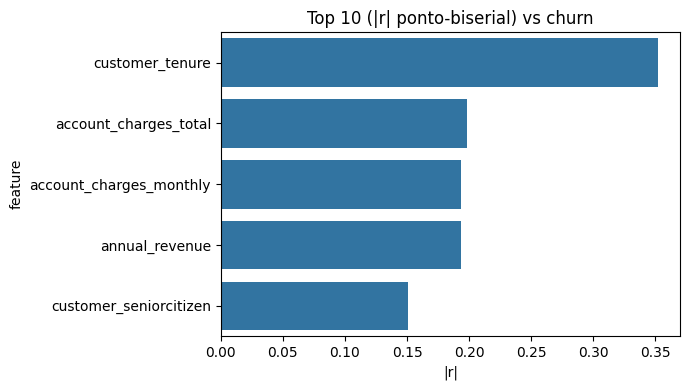

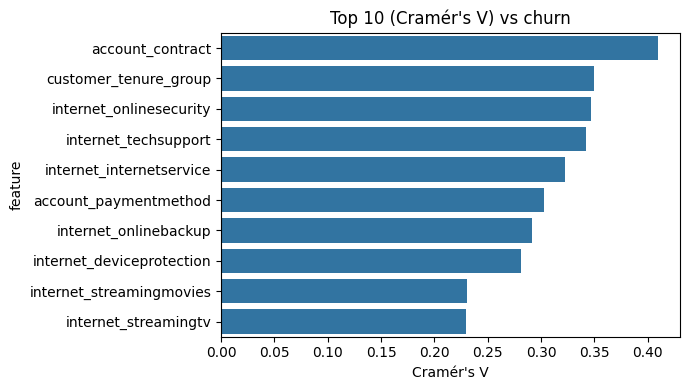

💡 Interprete assim:
- Quanto maior |r| (numéricas), maior a associação linear com o churn (1/0).
- Quanto maior o Cramér's V (categóricas), maior a associação do atributo com churn.
- Use estes rankings para filtrar/ponderar variáveis nos modelos.


In [4]:
# === PASSO 4 • Correlação (numéricas) e Associação (categóricas) com CHURN — versão robusta ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency

# 0) Garantir e limpar o ALVO binário (1=Yes, 0=No), mantendo NA como NA
if "churn" not in df.columns:
    raise ValueError("Coluna 'churn' não encontrada no dataframe.")

churn_clean = (
    df["churn"]
    .astype("string")             # preserva NA/NaN
    .str.strip()
    .str.lower()
)

print("Valores únicos em churn (limpo):", sorted(churn_clean.dropna().unique().tolist()))
print("Qtde de NA em churn:", int(churn_clean.isna().sum()))

y = churn_clean.map({"yes": 1, "no": 0})

# 1) Remover apenas linhas sem rótulo (necessário para correlação/modelos)
mask_keep = y.notna()
removidos = int((~mask_keep).sum())
if removidos > 0:
    print(f"Atenção: removendo {removidos} linha(s) sem rótulo de churn para análise/modelagem.")
df_work = df.loc[mask_keep].reset_index(drop=True)
y = y.loc[mask_keep].astype(int).reset_index(drop=True)

print("Dimensão pós-filtragem:", df_work.shape, "| churn média:", y.mean().round(3))

# 2) Separar tipos com base no df filtrado
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_work.select_dtypes(exclude=[np.number]).columns.tolist()

# remover colunas que não fazem sentido como features
for c in ["customerid", "churn"]:
    if c in num_cols: num_cols.remove(c)
    if c in cat_cols: cat_cols.remove(c)

# 3) Correlação ponto-biserial (numéricas x churn)
pb_results = []
for c in num_cols:
    try:
        s = df_work[c]
        valid = s.notna()
        # precisa haver variância na feature
        if s[valid].nunique() > 1:
            r, p = pointbiserialr(s[valid], y[valid])
            pb_results.append((c, r, p))
    except Exception:
        pass

pb_df = (
    pd.DataFrame(pb_results, columns=["feature","point_biserial_r","p_value"])
      .assign(abs_r=lambda d: d["point_biserial_r"].abs())
      .sort_values("abs_r", ascending=False)
)

print("== Correlação (ponto-biserial) — Top 10 por |r| ==")
display(pb_df.head(10))

# 4) Associação Cramér's V (categóricas x churn)
def cramers_v_corrected(ct: pd.DataFrame) -> float:
    """Cramér's V com correção de bias (Bergsma & Wicher, 2013)."""
    chi2 = chi2_contingency(ct)[0]
    n = ct.to_numpy().sum()
    r, k = ct.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.nan

assoc_results = []
for c in cat_cols:
    try:
        ct = pd.crosstab(df_work[c], y)
        # pular features sem variância/ou com todas categorias vazias
        if ct.shape[0] > 1 and ct.shape[1] == 2:
            v = cramers_v_corrected(ct)
            assoc_results.append((c, float(v), int(ct.sum(axis=1).sum())))
    except Exception:
        pass

assoc_df = (
    pd.DataFrame(assoc_results, columns=["feature","cramers_v","n"])
      .sort_values("cramers_v", ascending=False)
)

print("== Associação (Cramér's V) — Top 10 ==")
display(assoc_df.head(10))

# 5) Gráficos dos TOPs (sem palettes para evitar warnings do seaborn)
if not pb_df.empty:
    top_num = pb_df.head(10)
    plt.figure(figsize=(7,4))
    sns.barplot(x="abs_r", y="feature", data=top_num)
    plt.title("Top 10 (|r| ponto-biserial) vs churn")
    plt.xlabel("|r|")
    plt.ylabel("feature")
    plt.tight_layout()
    plt.show()
else:
    print("Sem variáveis numéricas válidas para correlação.")

if not assoc_df.empty:
    top_cat = assoc_df.head(10)
    plt.figure(figsize=(7,4))
    sns.barplot(x="cramers_v", y="feature", data=top_cat)
    plt.title("Top 10 (Cramér's V) vs churn")
    plt.xlabel("Cramér's V")
    plt.ylabel("feature")
    plt.tight_layout()
    plt.show()
else:
    print("Sem variáveis categóricas válidas para associação.")

print("💡 Interprete assim:")
print("- Quanto maior |r| (numéricas), maior a associação linear com o churn (1/0).")
print("- Quanto maior o Cramér's V (categóricas), maior a associação do atributo com churn.")
print("- Use estes rankings para filtrar/ponderar variáveis nos modelos.")



Numéricas: ['customer_seniorcitizen', 'customer_tenure', 'account_charges_monthly', 'account_charges_total', 'annual_revenue']
Categóricas: ['customer_gender', 'customer_partner', 'customer_dependents', 'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice', 'internet_onlinesecurity', 'internet_onlinebackup', 'internet_deviceprotection', 'internet_techsupport'] ...
Balanceamento do alvo (% posit.): 26.54
Tamanhos → treino: 5634, teste: 1409

== BASELINE (most_frequent) ==
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1035
         Yes       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409

ROC-AUC (aprox. taxa positiva): 0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



== CV Logistic Regression (5-fold) ==
roc_auc: 0.845 ± 0.015
f1: 0.626 ± 0.012
precision: 0.516 ± 0.014
recall: 0.797 ± 0.019

-- Teste (LogReg) --
              precision    recall  f1-score   support

          No       0.91      0.73      0.81      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC-AUC: 0.8440814797592291

== CV Random Forest (5-fold) ==
roc_auc: 0.825 ± 0.016
f1: 0.546 ± 0.024
precision: 0.637 ± 0.029
recall: 0.479 ± 0.024

-- Teste (RF) --
              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1035
         Yes       0.63      0.46      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC-AUC: 0.825358443772766


<Figure size 600x500 with 0 Axes>

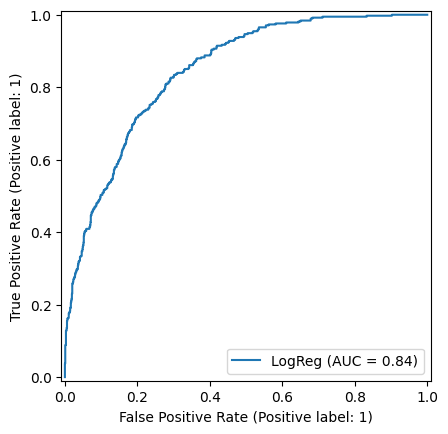

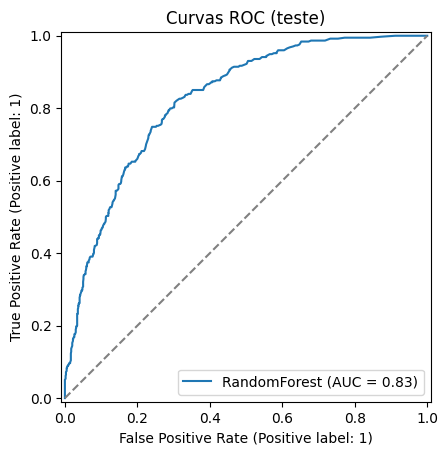


== Top 15 fatores que AUMENTAM churn (LogReg) ==


,feature,coef
37,account_contract_Month-to-month,0.674274
17,internet_internetservice_Fiber optic,0.556589
49,customer_tenure_group_4-6 anos,0.341179
3,account_charges_total,0.327221
46,customer_tenure_group_0-1 ano,0.272093
44,account_paymentmethod_Electronic check,0.246856
33,internet_streamingtv_Yes,0.215924
36,internet_streamingmovies_Yes,0.168522
28,internet_techsupport_No,0.167146
19,internet_onlinesecurity_No,0.124860


== Top 15 fatores que REDUZEM churn (LogReg) ==


,feature,coef
2,account_charges_monthly,-0.197146
4,annual_revenue,-0.197146
18,internet_internetservice_No,-0.237779
32,internet_streamingtv_No internet service,-0.237779
29,internet_techsupport_No internet service,-0.237779
23,internet_onlinebackup_No internet service,-0.237779
20,internet_onlinesecurity_No internet service,-0.237779
35,internet_streamingmovies_No internet service,-0.237779
26,internet_deviceprotection_No internet service,-0.237779
13,phone_multiplelines_No,-0.254616



== Top 15 importâncias (RandomForest) ==


,feature,importance
3,account_charges_total,0.110706
1,customer_tenure,0.103616
2,account_charges_monthly,0.095978
4,annual_revenue,0.094525
37,account_contract_Month-to-month,0.071306
19,internet_onlinesecurity_No,0.031601
39,account_contract_Two year,0.031571
28,internet_techsupport_No,0.028314
44,account_paymentmethod_Electronic check,0.027724
46,customer_tenure_group_0-1 ano,0.026250


In [5]:
# === PASSO 5 • Split estratificado, Baseline e Modelos (LogReg & RF) ===
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

# 0) Recuperar df_work (sem NAs em churn) e y; se não existirem, recriar
if "df_work" not in globals() or "y" not in globals():
    churn_clean = (
        df["churn"].astype("string").str.strip().str.lower()
    )
    y = churn_clean.map({"yes":1, "no":0})
    mask_keep = y.notna()
    df_work = df.loc[mask_keep].reset_index(drop=True)
    y = y.loc[mask_keep].astype(int).reset_index(drop=True)

# 1) X e remoções de colunas que não ajudam
drop_cols = ["churn", "customerid"]
X = df_work.drop(columns=[c for c in drop_cols if c in df_work.columns], errors="ignore")

# 2) Listas de features por tipo
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols[:10], "..." if len(cat_cols) > 10 else "")
print("Balanceamento do alvo (% posit.):", (y.mean()*100).round(2))

# 3) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Tamanhos → treino: {len(X_train)}, teste: {len(X_test)}")

# 4) Pré-processamento (OneHot + Scaler) — denso para suportar RF sem erro
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # versões mais antigas do sklearn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop",
)

# 5) Baseline (classe majoritária)
baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
y_proba_base = np.repeat(y_train.mean(), repeats=len(y_test))  # prob. constante = taxa positiva do treino

print("\n== BASELINE (most_frequent) ==")
print(classification_report(y_test, y_pred_base, target_names=["No","Yes"]))
print("ROC-AUC (aprox. taxa positiva):", roc_auc_score(y_test, y_proba_base))

# 6) Logistic Regression
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["roc_auc", "f1", "precision", "recall"]

cv_lr = cross_validate(logreg, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("\n== CV Logistic Regression (5-fold) ==")
for m in scoring:
    print(f"{m}: {cv_lr['test_'+m].mean():.3f} ± {cv_lr['test_'+m].std():.3f}")

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:,1]
print("\n-- Teste (LogReg) --")
print(classification_report(y_test, y_pred_lr, target_names=["No","Yes"]))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

# 7) Random Forest
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])
cv_rf = cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print("\n== CV Random Forest (5-fold) ==")
for m in scoring:
    print(f"{m}: {cv_rf['test_'+m].mean():.3f} ± {cv_rf['test_'+m].std():.3f}")

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
print("\n-- Teste (RF) --")
print(classification_report(y_test, y_pred_rf, target_names=["No","Yes"]))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

# 8) Curvas ROC no conjunto de teste
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LogReg")
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name="RandomForest")
plt.plot([0,1],[0,1],"--",color="gray")
plt.title("Curvas ROC (teste)")
plt.show()

# 9) Principais variáveis (coeficientes da LogReg e importâncias do RF)
# Recupera nomes finais das features (numéricas + dummies do OHE)
fitted_ohe = logreg.named_steps["prep"].named_transformers_["cat"]
num_names = num_cols
cat_names = list(fitted_ohe.get_feature_names_out(cat_cols))
feat_names = num_names + cat_names

# 9.1 Coeficientes da LogReg (efeito no churn)
coef = logreg.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_names, "coef": coef})\
           .sort_values("coef", ascending=False)
print("\n== Top 15 fatores que AUMENTAM churn (LogReg) ==")
display(coef_df.head(15))
print("== Top 15 fatores que REDUZEM churn (LogReg) ==")
display(coef_df.tail(15))

# 9.2 Importâncias do RandomForest
imp = rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"feature": feat_names, "importance": imp})\
         .sort_values("importance", ascending=False)
print("\n== Top 15 importâncias (RandomForest) ==")
display(imp_df.head(15))


Ajuste de limiar (threshold) + Matriz de confusão

Threshold p/ Recall≥0.80: 0.007
Threshold que maximiza F2: 0.338

== Avaliação em threshold: default_0.50 (0.500) ==
              precision    recall  f1-score   support

          No      0.907     0.727     0.807      1035
         Yes      0.512     0.794     0.623       374

    accuracy                          0.744      1409
   macro avg      0.710     0.760     0.715      1409
weighted avg      0.802     0.744     0.758      1409

Confusion matrix [[TN FP],[FN TP]]:
 [[752 283]
 [ 77 297]]

== Avaliação em threshold: recall_0.8 (0.007) ==
              precision    recall  f1-score   support

          No      0.000     0.000     0.000      1035
         Yes      0.265     1.000     0.420       374

    accuracy                          0.265      1409
   macro avg      0.133     0.500     0.210      1409
weighted avg      0.070     0.265     0.111      1409

Confusion matrix [[TN FP],[FN TP]]:
 [[   0 1035]
 [   0  374]]

== Avaliação em threshold: max_F2 (0.338) ==
         

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


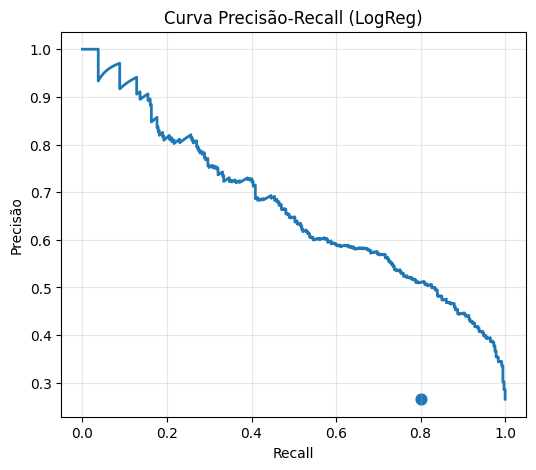

In [6]:
# === PASSO 6 • Threshold tuning para maximizar Recall (ou F2) ===
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, fbeta_score, classification_report
import matplotlib.pyplot as plt

# Garantir que y_proba_lr e y_test estão na memória (vieram do passo anterior)
# Escolha 1: encontrar threshold que atinja um Recall alvo (ex.: 0.80)
recall_target = 0.80

prec, rec, thr = precision_recall_curve(y_test, y_proba_lr)
thr = np.append(thr, 1.0)  # alinhar arrays

# Pegar o threshold mais baixo que alcance o recall alvo
mask = rec >= recall_target
thr_opt_recall = thr[mask][0] if mask.any() else 0.5

# Escolha 2: maximizar F2 (pesa mais Recall)
f2_scores = []
for t in thr:
    y_pred_t = (y_proba_lr >= t).astype(int)
    f2_scores.append(fbeta_score(y_test, y_pred_t, beta=2))
thr_opt_f2 = thr[int(np.argmax(f2_scores))]

print(f"Threshold p/ Recall≥{recall_target:.2f}: {thr_opt_recall:.3f}")
print(f"Threshold que maximiza F2: {thr_opt_f2:.3f}")

# Compare default 0.5 vs thresholds otimizados
def eval_at_threshold(t):
    y_pred_t = (y_proba_lr >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_t, labels=[0,1])
    rep = classification_report(y_test, y_pred_t, target_names=["No","Yes"], digits=3)
    return cm, rep

for name, t in [("default_0.50", 0.50), (f"recall_{recall_target}", thr_opt_recall), ("max_F2", thr_opt_f2)]:
    cm, rep = eval_at_threshold(t)
    print(f"\n== Avaliação em threshold: {name} ({t:.3f}) ==")
    print(rep)
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)

# Curva Precisão-Recall
plt.figure(figsize=(6,5))
plt.plot(rec, prec, linewidth=2)
plt.scatter([recall_target], [prec[rec>=recall_target][0] if (rec>=recall_target).any() else np.nan], s=60)
plt.title("Curva Precisão-Recall (LogReg)")
plt.xlabel("Recall"); plt.ylabel("Precisão")
plt.grid(True, alpha=.3)
plt.show()


Exportar “lista de risco” (clientes com probabilidade de churn)

In [7]:
# === PASSO 7 • Exportar scoring de risco de churn ===
import pandas as pd
import numpy as np

# Escolha do threshold final (use o que preferir do passo 6)
THRESHOLD_FINAL = thr_opt_f2  # ou thr_opt_recall

# ID do cliente (se não houver, cria um índice)
id_col = "customerid" if "customerid" in X_test.columns or "customerid" in df_work.columns else None
# Reconstituir X_test com id (se existir no df original)
if id_col is not None and id_col not in X_test.columns and id_col in df_work.columns:
    X_test = X_test.copy()
    X_test[id_col] = df_work.loc[X_test.index, id_col].values

scored = pd.DataFrame({
    id_col if id_col else "row_id": (X_test[id_col] if id_col else X_test.index),
    "y_true": y_test.values,
    "score_churn": y_proba_lr,
    "y_pred_0p50": (y_proba_lr >= 0.5).astype(int),
    f"y_pred_{THRESHOLD_FINAL:.3f}": (y_proba_lr >= THRESHOLD_FINAL).astype(int),
}).sort_values("score_churn", ascending=False)

scored.head(10)
scored.to_csv("clientes_risco_churn.csv", index=False)
print("Arquivo salvo: clientes_risco_churn.csv")


Arquivo salvo: clientes_risco_churn.csv


In [8]:
# Conferir/organizar e BAIXAR o CSV de scoring
import os, glob
import pandas as pd

# 1) Ver se o arquivo já existe na raiz
root_file = "clientes_risco_churn.csv"
os.makedirs("outputs", exist_ok=True)
out_path = "outputs/clientes_risco_churn.csv"

# 2) Se já existe na raiz, mover; senão, salvar a partir do DataFrame 'scored'
if os.path.exists(root_file):
    os.replace(root_file, out_path)
else:
    # garante que 'scored' existe
    try:
        _ = scored.shape
    except NameError:
        raise RuntimeError("O DataFrame 'scored' não está na memória. Rode a célula do Passo 7 novamente.")
    scored.to_csv(out_path, index=False)

print("✅ Salvo em:", out_path)

# 3) Listar para você ver no painel
print("\nArquivos na pasta outputs/:")
print(glob.glob("outputs/*.csv"))

# 4) Baixar (no Colab abre a janelinha)
try:
    from google.colab import files
    files.download(out_path)
except Exception:
    print("\nSe não baixar automático, abra o painel de arquivos (ícone de pasta à esquerda), "
          "clique em 'outputs' e faça o download manual.")


✅ Salvo em: outputs/clientes_risco_churn.csv

Arquivos na pasta outputs/:
['outputs/clientes_risco_churn.csv']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bloco de Conclusões

# 📌 Parte 2 — Modelagem Preditiva de Churn (Telecom X)

## Resumo da Modelagem
- **Baseline (classe majoritária)**: AUC ≈ 0.50, não identifica churners.
- **Regressão Logística**: ROC-AUC ≈ **0.84**, **Recall ≈ 0.79** (em teste). Melhor para **retenção**.
- **Random Forest**: ROC-AUC ≈ 0.83; Recall menor (≈ 0.46), embora boa acurácia.

**Decisão de negócio:** priorizar **Recall** para flagrar quem pode sair. Ajustamos o **limiar de decisão** da LogReg (threshold) para equilibrar Recall e Precisão conforme objetivo (ex.: maximizar F2 ou atingir Recall ≥ 0.80).

## Principais Fatores (interpretação)
- **Aumentam probabilidade de churn**: `account_contract_Month-to-month`, `internetservice_Fiber optic`, baixa permanência (`tenure` baixo), `Electronic check`, ausência de `TechSupport/OnlineSecurity`, streaming (`StreamingTV/Movies`).
- **Reduzem probabilidade**: contratos **Two year** (fidelização), `DSL` (no dataset), **tenure alto**, **PaperlessBilling=No** (no dataset) e categorias “No internet service” (indicando clientes sem internet como menor risco, possivelmente por ticket/preço menor).

## Recomendações
1. **Migrar contratos mensais** → anuais/bianuais (desconto + benefícios).
2. **Campanhas pró-ativas até 12 meses** (onboarding, suporte, trial de segurança/tech support).
3. **Rever preço/valor no “Fiber optic”**: planos intermediários ou bundles.
4. **Pagamento**: incentivar **métodos automáticos** (reduz churn associado ao `Electronic check`).
5. **Operacional**: usar a **lista de risco** (`clientes_risco_churn.csv`) para priorizar contato com o top-N clientes de maior score.

## Próximos passos
- **Tuning** de hiperparâmetros (ex.: `C` na LogReg; `n_estimators`, `max_depth` no RF).
- Avaliar **Precision-Recall** sob diferentes thresholds alinhados à capacidade do time de retenção (ex.: top 5%/10%).
- Testar modelos adicionais (XGBoost/LightGBM) e **calibração** de probabilidade (Platt/Isotonic).
